# 数据预处理

## 读取数据

In [1]:
# 读取数据
lung.cancer <- read.csv("lung-cancer.csv")

## 处理特征

In [2]:
# 数值型变量
num_columns <- c("Tumor.Size.Summary..2016..",
                 "Survival.months",
                 "Months.from.diagnosis.to.treatment",
                 "Age.recode.with.single.ages.and.90.")

# 将非数值型变量转化为 factor
lung.cancer[, !names(lung.cancer) %in% num_columns] <- lapply(lung.cancer[, !names(lung.cancer) %in% num_columns], as.factor)

# 去除 Tumor size 的缺失值
lung.cancer <- lung.cancer[lung.cancer$Tumor.Size.Summary..2016..<990, ]

# 去除 censored data
lung.cancer <- lung.cancer[lung.cancer$Year.of.death.recode != "Alive at last contact", ]

# 假定死亡发生在月末
lung.cancer$Survival.months <- lung.cancer$Survival.months + 1

# 按照 Survival.months 排序
lung.cancer <- lung.cancer[order(lung.cancer$Survival.months), ]

# 去除不需要的特征
columns_to_remove <- c("Patient.ID",
                       "Year.of.follow.up.recode",
                       "Regional.nodes.positive..1988..",
                       "Regional.nodes.examined..1988..",
                       "EOD.Regional.Nodes..2018..",
                       "EOD.Mets..2018..",
                       "Radiation.recode",
                       "Behavior.code.ICD.O.3",
                       "Grade.Clinical..2018..",
                       "Grade.Pathological..2018..",
                       "Rural.Urban.Continuum.Code",
                       "Median.household.income.inflation.adj.to.2021",
                       "Marital.status.at.diagnosis",
                       "Visceral.and.Parietal.Pleural.Invasion.Recode..2010..",
                       "Derived.EOD.2018.T..2018..",
                       "Derived.EOD.2018.N..2018..",
                       "Derived.EOD.2018.M..2018..",
                       "Derived.EOD.2018.Stage.Group..2018..",
                       "RX.Summ..Surg.Rad.Seq",
                       "RX.Summ..Systemic.Sur.Seq..2007..",
                       "EOD.Primary.Tumor..2018..",
                       "Chemotherapy.recode..yes..no.unk.",
                       "Separate.Tumor.Nodules.Ipsilateral.Lung.Recode..2010..",
                       "Histology.recode...broad.groupings",
                       "Year.of.death.recode",
                       "Year.of.diagnosis")
lung.cancer <- lung.cancer[, !names(lung.cancer) %in% columns_to_remove]


# 描述性统计

# 数据建模

In [3]:
summarize.model <- function(model, filename){
    model.summary <- summary(model)
    output <- capture.output(model.summary)
    writeLines(output, filename)
}

## 线性模型

### 模型拟合

In [4]:
linear.model <- lm(Survival.months ~ ., data=lung.cancer)
summarize.model(linear.model, "./model-summary/linear_model_summary.txt")

### 预测图像

In [5]:
y_pred <- predict(linear.model, newdata = lung.cancer)
y_true <- lung.cancer$Survival.months
result_df <- data.frame(Actual = y_true, Predicted = y_pred)
library(ggplot2)
linear.prediction <- ggplot(result_df, aes(x = 1:length(y_true))) +
                     geom_line(aes(y = Actual, color = "Actual"), linewidth = 1) +
                     geom_line(aes(y = Predicted, color = "Predicted"), linetype = "dashed", linewidth = 1) +
                     labs(title = "Actual vs Predicted Over Observations",
                     x = "Observations", y = "Values") +
                     scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red"))
ggsave("./figures/linear_prediction.png", linear.prediction, width = 8, height = 6, dpi = 300)

## 广义线性模型(y分布如何选择?)

### 模型拟合

In [6]:
library(MASS)
glinear.model <- glm.nb(Survival.months ~ ., data=lung.cancer) # 负二项分布
summarize.model(glinear.model, "./model-summary/generalized_linear_model_summary.txt")

### 预测图像

In [7]:
y_pred <- predict(glinear.model, newdata = lung.cancer)
y_true <- lung.cancer$Survival.months
result_df <- data.frame(Actual = y_true, Predicted = y_pred)
glinear.prediction <- ggplot(result_df, aes(x = 1:length(y_true))) +
                     geom_line(aes(y = Actual, color = "Actual"), linewidth = 1) +
                     geom_line(aes(y = Predicted, color = "Predicted"), linetype = "dashed", linewidth = 1) +
                     labs(title = "Actual vs Predicted Over Observations",
                     x = "Observations", y = "Values") +
                     scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red"))
ggsave("./figures/glinear_prediction.png", glinear.prediction, width = 8, height = 6, dpi = 300)

## box-cox

### 模型拟合

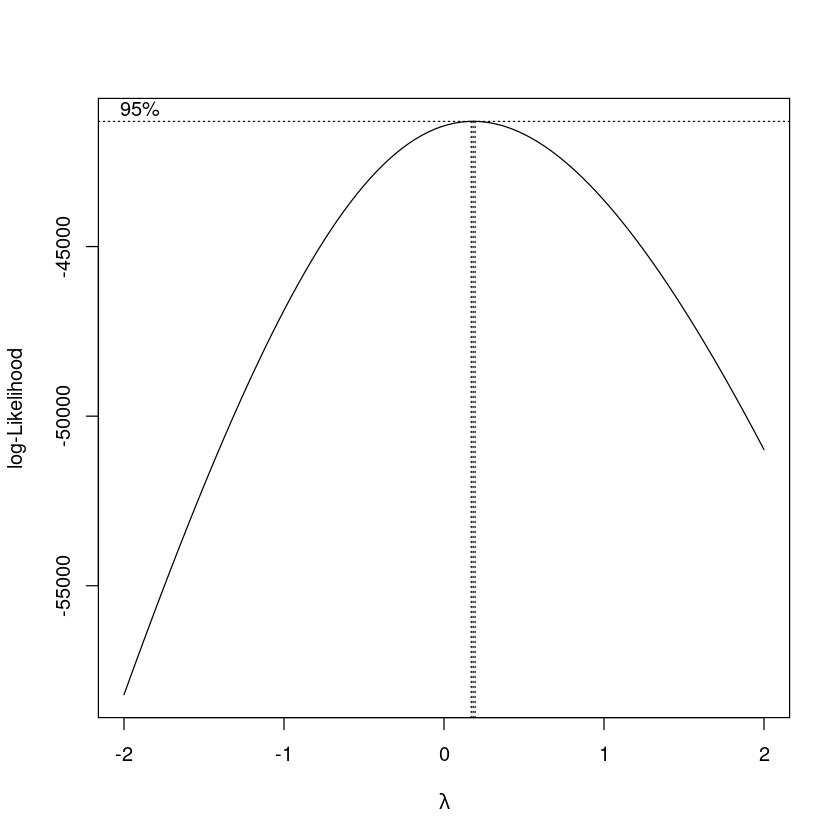

In [8]:
boxcox.model <- boxcox(Survival.months ~ ., data = lung.cancer)
lambda <- boxcox.model$x[which.max(boxcox.model$y)]
bclinear.model <- lm((Survival.months^lambda - 1)/lambda ~ ., data = lung.cancer)
summarize.model(bclinear.model, "./model-summary/boxcox_linear_model_summary.txt")

### 预测图像

In [9]:
y_pred <- predict(bclinear.model, newdata = lung.cancer)
y_true <- (lung.cancer$Survival.months^lambda - 1)/lambda
result_df <- data.frame(Actual = y_true, Predicted = y_pred)
bclinear.prediction <- ggplot(result_df, aes(x = 1:length(y_true))) +
                     geom_line(aes(y = Actual, color = "Actual"), linewidth = 1) +
                     geom_line(aes(y = Predicted, color = "Predicted"), linetype = "dashed", linewidth = 1) +
                     labs(title = "Actual vs Predicted Over Observations",
                     x = "Observations", y = "Values") +
                     scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red"))
ggsave("./figures/bclinear_prediction.png", bclinear.prediction, width = 8, height = 6, dpi = 300)

## 岭回归

### 模型拟合

In [10]:
library(glmnet)
lung.cancer.x <- lung.cancer[, !(names(lung.cancer) %in% c("Survival.months"))]
lung.cancer.y <- lung.cancer$Survival.months
rlinear.model <- glmnet(lung.cancer.x, lung.cancer.y, alpha = 0, lambda = seq(from = 1, to = 1000, by = 1))

Loading required package: Matrix

Loaded glmnet 4.1-8



### 预测图像

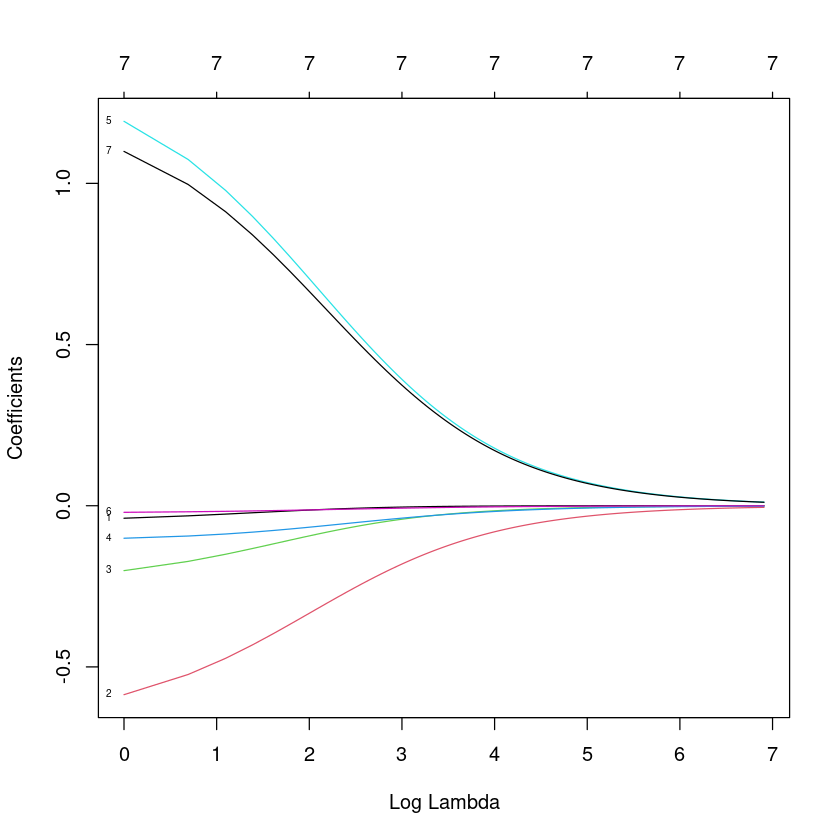

In [11]:
plot(rlinear.model, xvar = "lambda", label = TRUE)